In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/bank.csv"
BankData = pd.read_csv(url)
BankData.head(5)

,age,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,30,married,primary,no,1787,no,no,cellular,79,1,-1,0,unknown,no
1,33,married,secondary,no,4789,yes,yes,cellular,220,1,339,4,failure,no
2,35,single,tertiary,no,1350,yes,no,cellular,185,1,330,1,failure,no
3,30,married,tertiary,no,1476,yes,yes,unknown,199,4,-1,0,unknown,no
4,59,married,secondary,no,0,yes,no,unknown,226,1,-1,0,unknown,no


In [3]:
BankData['y'].unique()  #you can use unique if you would like to find out how many unique attributes each variable have

array(['no', 'yes'], dtype=object)

For dictionary of data please refer to https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

#### Our goal is to define a model best predicts outcome y - success of the marketing campaign 

First let's create dummy variables for default, marital, housing, and loan

In [4]:
Default_dummy  = pd.get_dummies(BankData['default'], prefix = 'default')
del Default_dummy['default_no']

marital_dummy  = pd.get_dummies(BankData['marital'], prefix = 'marital')
del marital_dummy['marital_married']
del marital_dummy['marital_divorced']

housing_dummy  = pd.get_dummies(BankData['housing'], prefix = 'housing')
del housing_dummy['housing_no']

loan_dummy = pd.get_dummies(BankData['loan'], prefix = 'loan')
del loan_dummy['loan_no']


BankData = pd.concat([BankData,marital_dummy , Default_dummy, housing_dummy, loan_dummy], axis=1)
BankData.head()



,age,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,marital_single,default_yes,housing_yes,loan_yes
0,30,married,primary,no,1787,no,no,cellular,79,1,-1,0,unknown,no,0,0,0,0
1,33,married,secondary,no,4789,yes,yes,cellular,220,1,339,4,failure,no,0,0,1,1
2,35,single,tertiary,no,1350,yes,no,cellular,185,1,330,1,failure,no,1,0,1,0
3,30,married,tertiary,no,1476,yes,yes,unknown,199,4,-1,0,unknown,no,0,0,1,1
4,59,married,secondary,no,0,yes,no,unknown,226,1,-1,0,unknown,no,0,0,1,0


In [5]:
X = BankData[['age','balance','duration','campaign','pdays','previous','marital_single','default_yes','housing_yes','loan_yes']]
y = BankData['y']

In [6]:
lm = LogisticRegression()
lm.fit(X,y)
print lm.coef_
print lm.intercept_

[[  1.44147154e-03   1.06013143e-05   3.78470944e-03  -9.08027649e-02
    2.42750471e-03   9.52575916e-02   1.70756136e-01   1.39183922e-01
   -9.89177021e-01  -8.53854268e-01]]
[-2.84003947]


#### What is your 10-fold cross-validation error?

In [7]:
from sklearn.cross_validation import cross_val_score
print(1 - cross_val_score(lm,X,y,cv=10).mean())

# it is around 10.9%

0.109708628807


#### Construct a confusion matrix.

In [8]:
from sklearn.metrics import confusion_matrix
y_hat = lm.predict(X)
confusion_matrix(y_hat,y)

array([[3923,  425],
       [  77,   96]])

#### Interpret your coefficients. (At least interpret campaign, marital_single, and default_yes. Do your interpretations  make sense?

In [9]:
print(np.exp(-0.08814166) - 1)
print(np.exp(0.25293566) - 1)
print(np.exp(0.19872026 ) - 1)

-0.0843688407744
0.28780041709
0.219840679935


Answer: For every extra time a client is contacted - the odds of usefulness of marketing campaign decreases by 8.4% - may be clients get frustrated.

The odds of singletones are targeted successfully by this campaign is 28.7% more than married people. Perhaps if people are married they need to consult with their spouse but singletones can decide on themselves.

The odds of effectiveness of this campaign on those people who have previously defaulted on their loans is 21.9% more than those who did not. This may suggest that those who are reponsible borrowers are more careful with how to respond to bank offers.  

#### What is your prediction for a person who is 30 years old, 1000 dollars balance,  with duration = 210 , has been contacted 3 times for this campaign (campaign = 3), with pdays = 100, who has previously been contacted 4 times, who is single, never defaulted, home owner and doesn't have any loan?

In [10]:
x1 = [[30,1000,210,3,100,4,1,0,1,0]]
print(lm.predict(x1))  # our prediction is that our campaign will not be successful
print(lm.predict_proba(x1))  # Probability of success is only 7.8 percent

['no']
[[ 0.92117744  0.07882256]]


#### Now standardize your data - you can use standardization method used for KNN algorithms.

In [11]:
def Standardize(X):
    X_Max = X.max()
    X_Min = X.min()
    X_Standardized = (X-X_Min)/(X_Max - X_Min)
    return X_Standardized

NameOfVariables = ['age','balance','duration','campaign','pdays','previous','marital_single','default_yes','housing_yes','loan_yes']
for i in NameOfVariables:
    BankData[i] = Standardize(BankData[i])
    
X = BankData[['age','balance','duration','campaign','pdays','previous','marital_single','default_yes','housing_yes','loan_yes']]    

#### Use 10-fold cross validation to find the best tuning parameter - C.

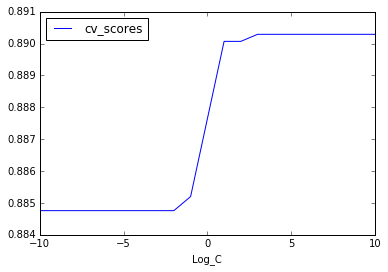

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
# Try testing and plot
c_list = np.logspace(-10,10,21) 
c_index = np.linspace(-10,10,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score)
    cv_scores.append(cross_val_score(lm,X,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )
# our choice is Log_C = 0
# it sounds like our precision is best at around C = 10

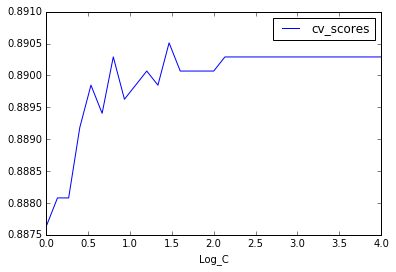

In [13]:
c_list = np.logspace(0,4,31) 
c_index = np.linspace(0,4,31)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score)
    cv_scores.append(cross_val_score(lm,X,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )

# By limiting our search only around the optimal solution we again found that log_c = 1.5, therefore, c = 10**1.5 is our best bet

#### Now use the best C you found above and repeat your analysis and look over your coefficients

In [14]:
lm = LogisticRegression(C = 10**1.5)
lm.fit(X,y)
print(lm.coef_)


[[  0.63496704   0.84101122  11.44777066  -3.85000346   2.13403264
    2.38704481   0.30831829   0.36097654  -0.90683096  -0.83339542]]


In [15]:
#Now zip name of variables and your coefficients
Var_coef = zip(lm.coef_[0,:],NameOfVariables)
print Var_coef

[(0.63496704147102412, 'age'), (0.84101121915710841, 'balance'), (11.447770657793702, 'duration'), (-3.8500034618679475, 'campaign'), (2.1340326421521278, 'pdays'), (2.3870448059462208, 'previous'), (0.30831829147827994, 'marital_single'), (0.36097653721473494, 'default_yes'), (-0.90683095622214382, 'housing_yes'), (-0.83339541559895924, 'loan_yes')]


#### If you would like to drop 3 variables from your analysis, which variables are you going to choose?

Answer: Marital_single, default_yes, and age since they have the smallest coefficient under the optimal C. Loan and housing had the highest coefficients.  

In [16]:
sorted(Var_coef) #you can sort it and then look at the values - please pay attention to negative coefficients

[(-3.8500034618679475, 'campaign'),
 (-0.90683095622214382, 'housing_yes'),
 (-0.83339541559895924, 'loan_yes'),
 (0.30831829147827994, 'marital_single'),
 (0.36097653721473494, 'default_yes'),
 (0.63496704147102412, 'age'),
 (0.84101121915710841, 'balance'),
 (2.1340326421521278, 'pdays'),
 (2.3870448059462208, 'previous'),
 (11.447770657793702, 'duration')]